In [1]:
from datasets import load_dataset

ds = load_dataset("YuvrajSingh9886/Agriculture-Soil-QA-Pairs-Dataset")

In [7]:
import pandas as pd
ds

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'ANSWER', 'QUESTION.question', 'QUESTION.paragraph'],
        num_rows: 3447
    })
})

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import evaluate
import re
from transformers import (
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    T5Tokenizer,
    default_data_collator,
    T5ForConditionalGeneration,
    DataCollatorForSeq2Seq
)
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM
from transformers import pipeline
from transformers import set_seed
set_seed(42)

In [3]:
split_dataset = ds["train"].train_test_split(test_size=0.2, seed=42)
split_dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'ANSWER', 'QUESTION.question', 'QUESTION.paragraph'],
        num_rows: 2757
    })
    test: Dataset({
        features: ['Unnamed: 0', 'ANSWER', 'QUESTION.question', 'QUESTION.paragraph'],
        num_rows: 690
    })
})

In [8]:
questions = ["question:" + q for q in split_dataset['train']['QUESTION.question']]
answers = [a for a in split_dataset['train']['ANSWER']]

df = pd.DataFrame({'questions': questions, 'answers': answers})
df

,questions,answers
0,question:What is often rewarded under agri-env...,Semi-natural habitats
1,question:When can the harvesting process for t...,The harvesting process for these crops can gen...
2,question:What can help optimize nutrient cycle...,Variety and species mixtures (intercrops).
3,question:What is included in the assessment of...,Number of earthworm burrows and extent of visi...
4,question:How can soil-borne pest build-up asso...,Soil-borne pest build-up can be avoided by pra...
...,...,...
2752,question:Why is it important to incorporate th...,To ensure minimal nitrogen loss
2753,question:How do microbes contribute to nutrien...,Microbes contribute to nutrient availability b...
2754,question:How does the hand texturing method cl...,"In the hand texturing method, soil that forms ..."
2755,question:List methods to minimize soil compact...,"To minimize soil compaction from machinery, on..."


In [ ]:
model = AutoModelForCausalLM.from_pretrained("persadian/CropSeek-LLM")
tokenizer = AutoTokenizer.from_pretrained("persadian/CropSeek-LLM")

max_input_length  =  256
max_target_length =   64

def preprocess(batch):
    inputs = ["question: " + q.strip() for q in batch["question"]]
    targets = [a[0] if isinstance(a, list) else a for a in batch["answers"]]
    
    model_inputs = tokenizer(inputs, 
                             max_length=max_input_length, 
                             truncation=True, 
                             padding=True)
    labels = tokenizer(targets, 
                       max_length=max_target_length, 
                       truncation=True, 
                       padding=True)
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_dataset = split_dataset["train"].map(preprocess, batched=True)
test_dataset = split_dataset["test"].map(preprocess, batched=True)



You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [7]:
rouge = evaluate.load("rouge")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if hasattr(preds, "dim"):
        preds = preds.argmax(dim=-1)
    else:
        preds = np.argmax(preds, axis=-1)

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = [[(l if l != -100 else tokenizer.pad_token_id) for l in label] for label in labels]
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds = ["\n".join(pred.strip().split(". ")) for pred in decoded_preds]
    decoded_labels = ["\n".join(label.strip().split(". ")) for label in decoded_labels]

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    
    result = {key: round(value * 100, 4) for key, value in result.items()}

    return result


In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

training_args = Seq2SeqTrainingArguments(
    output_dir = "./CropSeek-LLM",
    per_device_train_batch_size = 8,
    gradient_accumulation_steps = 4,
    num_train_epochs = 3,
    learning_rate = 5e-5,
    evaluation_strategy = "epoch",      
    save_strategy = "epoch",             
    logging_dir = "./logs",             
    logging_steps = 10,
    predict_with_generate = True,
    fp16 = True,
    save_total_limit = 2,
)

trainer = Seq2SeqTrainer(
    model             = model,
    args              = training_args,
    train_dataset     = train_dataset,
    eval_dataset      = test_dataset,
    data_collator     = data_collator,
    tokenizer         = tokenizer,
    compute_metrics   = compute_metrics,
)

In [9]:
trainer.train()
trainer.save_model("./CropSeek-LLM") 

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,1.003900,0.803022,1.052500,0.000000,1.052800,1.052800
2,0.752400,0.579151,1.056000,0.000000,1.060400,1.054800


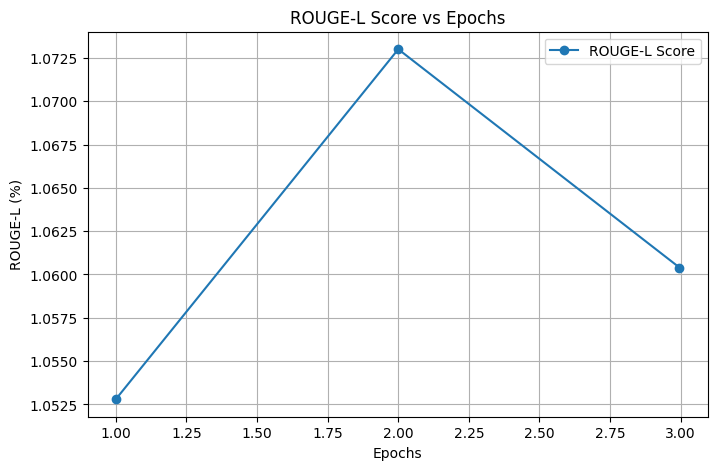

In [3]:
import json


# Read all log files (they are saved in 'trainer_state.json')
with open("Cropseek-LLM/checkpoint-1695/trainer_state.json", "r") as f:
    logs = json.load(f)

training_logs = logs["log_history"]

# Extract rougeL scores and epochs
epochs = []
rougeL = []

for log in training_logs:
    if "eval_rougeL" in log:
        epochs.append(log["epoch"])
        rougeL.append(log["eval_rougeL"])

# Plot
plt.figure(figsize=(8,5))
plt.plot(epochs, rougeL, marker="o", label="ROUGE-L Score")
plt.title("ROUGE-L Score vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("ROUGE-L (%)")
plt.grid(True)
plt.legend()
plt.show()
